In [1]:
%matplotlib inline
import numpy as np
import numpy.fft as fft
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display
import cv2

from utils.utils import *

In [2]:
"""Stuff that is normally in the config file"""
psfname = "tutorial/psf_sample.tif"
imgname = "tutorial/rawdata_hand_sample.tif"

# # Downsampling factor (used to shrink images)
# f = 0.25

# # Hyper-parameters in the ADMM implementation (like step size in GD)
# mu1 = 1e-6
# mu2 = 1e-5
# mu3 = 4e-5
# tau = 0.0001

# # Number of iterations
# iters = 5

In [3]:
def loadData(show_im=True):
    psf = Image.open(psfname)
    psf = np.array(psf, dtype='float32')
    data = Image.open(imgname)
    data = np.array(data, dtype='float32')
    
    """In the picamera, there is a non-trivial background 
    (even in the dark) that must be subtracted"""
    bg = np.mean(psf[5:15,5:15]) 
    psf -= bg
    data -= bg
    
    """Resize to a more manageable size to do reconstruction on. 
    Because resizing is downsampling, it is subject to aliasing 
    (artifacts produced by the periodic nature of sampling). Demosaicing is an attempt
    to account for/reduce the aliasing caused. In this application, we do the simplest
    possible demosaicing algorithm: smoothing/blurring the image with a box filter"""
    
    def resize(img, factor):
        num = int(-np.log2(factor))
        for i in range(num):
            img = 0.25*(img[::2,::2,...]+img[1::2,::2,...]+img[::2,1::2,...]+img[1::2,1::2,...])
        return img
    
    
    psf = resize(psf, f)
    data = resize(data, f)
    
    """Now we normalize the images so they have the same total power. Technically not a
    necessary step, but the optimal hyperparameters are a function of the total power in 
    the PSF (among other things), so it makes sense to standardize it"""
    
    psf /= np.linalg.norm(psf.ravel())
    data /= np.linalg.norm(data.ravel())
    
    if show_im:
        fig1 = plt.figure()
        plt.imshow(psf, cmap='gray')
        plt.title('PSF')
#         display.display(fig1)
        fig2 = plt.figure()
        plt.imshow(data, cmap='gray')
        plt.title('Raw data')
#         display.display(fig2)
    return psf, data

In [4]:
"""The "uncropped" size of the image. As with the gradient descent, we pad the images 
so that convolution is linear instead of circular"""
# psf, data = loadData(True)
# sensor_size = np.array(psf.shape)
# full_size = 2*sensor_size

'The "uncropped" size of the image. As with the gradient descent, we pad the images \nso that convolution is linear instead of circular'

In [5]:
def U_update(eta, image_est, tau):
    return SoftThresh(Psi(image_est) + eta/mu2, tau/mu2)

In [6]:
def SoftThresh(x, tau):
    # numpy automatically applies functions to each element of the array
    return np.sign(x)*np.maximum(0, np.abs(x) - tau)

In [7]:
def Psi(v):
    return np.stack((np.roll(v,1,axis=0) - v, np.roll(v, 1, axis=1) - v), axis=2)

In [8]:
def X_update(xi, image_est, H_fft, sensor_reading, X_divmat):
    return X_divmat * (xi + mu1*M(image_est, H_fft) + CT(sensor_reading))

In [9]:
def M(vk, H_fft):
    return np.real(fft.fftshift(fft.ifft2(fft.fft2(fft.ifftshift(vk))*H_fft)))

In [10]:
def C(M):
    # Image stored as matrix (row-column rather than x-y)
    top = (full_size[0] - sensor_size[0])//2
    bottom = (full_size[0] + sensor_size[0])//2
    left = (full_size[1] - sensor_size[1])//2
    right = (full_size[1] + sensor_size[1])//2
    return M[top:bottom,left:right]

def CT(b):
    v_pad = (full_size[0] - sensor_size[0])//2
    h_pad = (full_size[1] - sensor_size[1])//2
    return np.pad(b, ((v_pad, v_pad), (h_pad, h_pad)), 'constant',constant_values=(0,0))

In [11]:
def precompute_X_divmat(): 
    """Only call this function once! 
    Store it in a variable and only use that variable 
    during every update step"""
    return 1./(CT(np.ones(sensor_size)) + mu1)

In [12]:
def W_update(rho, image_est):
    return np.maximum(rho/mu3 + image_est, 0)

In [13]:
def r_calc(w, rho, u, eta, x, xi, H_fft):
    return (mu3*w - rho)+PsiT(mu2*u - eta) + MT(mu1*x - xi, H_fft)

def V_update(w, rho, u, eta, x, xi, H_fft, R_divmat):
    freq_space_result = R_divmat*fft.fft2( fft.ifftshift(r_calc(w, rho, u, eta, x, xi, H_fft)) )
    return np.real(fft.fftshift(fft.ifft2(freq_space_result)))

In [14]:
def PsiT(U):
    diff1 = np.roll(U[...,0],-1,axis=0) - U[...,0]
    diff2 = np.roll(U[...,1],-1,axis=1) - U[...,1]
    return diff1 + diff2

In [15]:
def MT(x, H_fft):
    x_zeroed = fft.ifftshift(x)
    return np.real(fft.fftshift(fft.ifft2(fft.fft2(x_zeroed) * np.conj(H_fft))))

In [16]:
def precompute_PsiTPsi():
    PsiTPsi = np.zeros(full_size)
    PsiTPsi[0,0] = 4
    PsiTPsi[0,1] = PsiTPsi[1,0] = PsiTPsi[0,-1] = PsiTPsi[-1,0] = -1
    PsiTPsi = fft.fft2(PsiTPsi)
    return PsiTPsi

In [17]:
def precompute_R_divmat(H_fft, PsiTPsi): 
    """Only call this function once! 
    Store it in a variable and only use that variable 
    during every update step"""
    MTM_component = mu1*(np.abs(np.conj(H_fft)*H_fft))
    PsiTPsi_component = mu2*np.abs(PsiTPsi)
    id_component = mu3
    """This matrix is a mask in frequency space. So we will only use
    it on images that have already been transformed via an fft"""
    return 1./(MTM_component + PsiTPsi_component + id_component)

In [18]:
def xi_update(xi, V, H_fft, X):
    return xi + mu1*(M(V,H_fft) - X)

def eta_update(eta, V, U):
    return eta + mu2*(Psi(V) - U)

def rho_update(rho, V, W):
    return rho + mu3*(V - W)

In [19]:
def init_Matrices(H_fft):
    X = np.zeros(full_size)
    U = np.zeros((full_size[0], full_size[1], 2))
    V = np.zeros(full_size)
    W = np.zeros(full_size)

    xi = np.zeros_like(M(V,H_fft))
    eta = np.zeros_like(Psi(V))
    rho = np.zeros_like(W)
    return X,U,V,W,xi,eta,rho

In [20]:
def precompute_H_fft(psf):
    return fft.fft2(fft.ifftshift(CT(psf)))

In [21]:
def ADMMStep(X,U,V,W,xi,eta,rho, precomputed):
    H_fft, data, X_divmat, R_divmat = precomputed
    U = U_update(eta, V, tau)
    X = X_update(xi, V, H_fft, data, X_divmat)
    V = V_update(W, rho, U, eta, X, xi, H_fft, R_divmat)
    W = W_update(rho, V)
    xi = xi_update(xi, V, H_fft, X)
    eta = eta_update(eta, V, U)
    rho = rho_update(rho, V, W)
    
    return X,U,V,W,xi,eta,rho

In [22]:
def runADMM(psf, data):
    H_fft = precompute_H_fft(psf)
    X,U,V,W,xi,eta,rho = init_Matrices(H_fft)
    X_divmat = precompute_X_divmat()
    PsiTPsi = precompute_PsiTPsi()
    R_divmat = precompute_R_divmat(H_fft, PsiTPsi)
    
    for i in range(iters):
        X,U,V,W,xi,eta,rho = ADMMStep(X,U,V,W,xi,eta,rho, [H_fft, data, X_divmat, R_divmat])
        if i % 1 == 0:
            image = C(V)
            image[image<0] = 0
            f = plt.figure(1)
            plt.imshow(image, cmap='gray')
            plt.title('Reconstruction after iteration {}'.format(i))
            display.display(f)
            display.clear_output(wait=True)
    return image

In [23]:
# Load target image (for reconstruction)
data = np.load('../../Desktop/datasets/LenslessLearning/ground_truth_lensed/im65.npy')
print(data.shape)
data = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
data /= np.linalg.norm(data.ravel())

# Create Radial mask
psf = create_mask(mask_shape=(270, 480, 3), n_rays=24, white_pixel_ratio=True)
# psf /= psf.sum()
psf /= np.linalg.norm(psf.ravel())

sensor_size = np.array(psf.shape)
full_size = 2*sensor_size

sensor_meas = C(M(CT(data), precompute_H_fft(psf)))

(270, 480, 3)


In [24]:
mu1 = 1e-7
mu2 = 1e-6
mu3 = 4e-6
tau = 0.00001

# Number of iterations
iters = 40

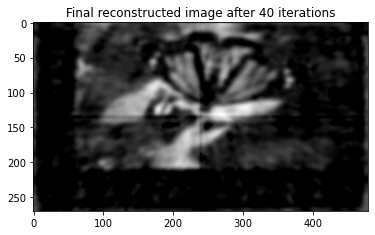

In [25]:
#psf, data = loadData(True)
# final_im = runADMM(psf, data)
final_im = runADMM(psf, sensor_meas)
plt.imshow(final_im, cmap='gray')
plt.title('Final reconstructed image after {} iterations'.format(iters))
display.display()

([], [])

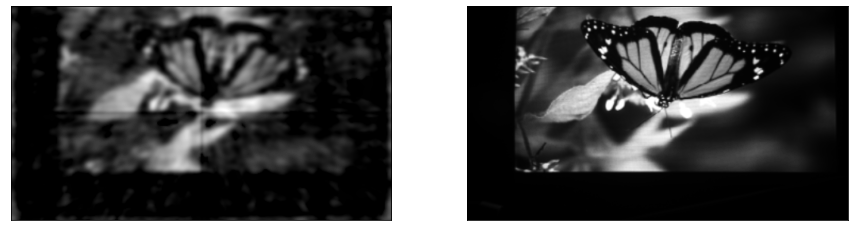

In [26]:
plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.imshow(final_im, cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(data, cmap='gray')
plt.xticks([])
plt.yticks([])